In [1]:
import torch

In [2]:

class RNN(torch.nn.Module):

  def __init__(self, d_in, d_hidden):
    super().__init__()
    self._d_hidden = d_hidden
    self._d_in = d_in
    self._w_ih = torch.nn.Parameter(torch.randn((d_hidden, d_in)))
    self._b_ih = torch.nn.Parameter(torch.randn(d_hidden))
    self._w_hh = torch.nn.Parameter(torch.randn((d_hidden, d_hidden)))
    self._b_hh = torch.nn.Parameter(torch.randn(d_hidden))

  def forward(self, x, h = None):
    L = x.shape[0]
    device = self._w_ih.device
    if h is None:
        h = torch.zeros(self._d_hidden).to(device)
    out = []
    for t in range(L):
      h = torch.tanh(x[t] @ self._w_ih.t() + self._b_ih + h @ self._w_hh.t() + self._b_hh)
      out.append(h)
    return torch.stack(out), h

In [3]:

class MyModel(torch.nn.Module):

  def __init__(self, d_in, d_hidden):
    self._d_hidden = d_hidden
    self._d_in = d_in
    super().__init__()
    self._rnn = RNN(d_in = d_in, d_hidden = d_hidden)
    self._linear = torch.nn.Linear(in_features = d_hidden, out_features = d_in)

  def forward(self, x, h = None):
    rnn_out, hidden = self._rnn(x, h)
    out = self._linear(rnn_out)
    return out, hidden 

In [4]:

class CounterDataSet(torch.utils.data.Dataset):

  def __init__(self, V, L):
    super().__init__()
    self._V = V
    self._L = L

  def __getitem__(self, index):
    if not index < len(self):
      raise KeyError
    #
    # Input at index is the sequence of length L 
    # starting at index
    #
    inputs = torch.arange(index, index + self._L, dtype = torch.long)
    targets = torch.arange(index + 1, index + self._L + 1, dtype = torch.long)
    inputs = torch.nn.functional.one_hot(inputs, num_classes = self._V)
    inputs = inputs.to(torch.float32)
    return inputs, targets

  def __len__(self):
    return self._V - self._L


def collate_fn(list):
    X = []
    Y = []
    for index, [x, y] in enumerate(list):
        Y.append(y)
        X.append(x)
    #
    # Stack along batch dimension
    #        
    X = torch.stack(X, dim = 1)
    Y = torch.stack(Y, dim = 1)
    return X, Y 

In [5]:
def train(model, epochs, train_data_loader, lr = 0.025, device = "cpu", loss_fn = torch.nn.functional.cross_entropy):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    lr_lambda = lambda epoch: (epochs - epoch) / epochs
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda, verbose = False)
    for epoch in range(epochs):
        epoch_loss = 0
        items_in_epoch = 0
        for X, Y in train_data_loader:
            items_in_epoch = items_in_epoch + 1
            f, hidden = model(X.to(device))
            targets = Y.to(device)
            #
            # f is the model output and has shape (L, B, V)
            # targets are the targets and have shape (L, B) 
            # so we first flatten them
            #
            V = f.shape[2]
            f = f.view(-1, V)
            targets = targets.flatten()
            loss = loss_fn(f, targets)            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            epoch_loss = epoch_loss + loss.item()

        epoch_loss = epoch_loss / items_in_epoch
        scheduler.step()

    return losses

def eval_model(model, V, device):
  L = 3
  eval_ds = CounterDataSet(V = V, L = L)
  accuracy = 0
  for i in range(len(eval_ds)):
    inputs, targets = eval_ds[i]
    out, _ = model(inputs.to(device))
    p = torch.softmax(out[-1], dim = 0)
    guess = torch.argmax(p).item()
    if guess == targets[-1]:
      accuracy += 1
  accuracy = accuracy / len(eval_ds)
  return accuracy

Using device cuda
Sequence length 4 ---> accuracy 0.992
Sequence length 5 ---> accuracy 0.984
Sequence length 6 ---> accuracy 0.992
Sequence length 7 ---> accuracy 0.984
Sequence length 8 ---> accuracy 0.992
Sequence length 9 ---> accuracy 0.944
Sequence length 10 ---> accuracy 0.688
Sequence length 11 ---> accuracy 0.52
Sequence length 12 ---> accuracy 0.24
Sequence length 13 ---> accuracy 0.464
Sequence length 14 ---> accuracy 0.208
Sequence length 15 ---> accuracy 0.136
Sequence length 16 ---> accuracy 0.12
Sequence length 17 ---> accuracy 0.072
Sequence length 18 ---> accuracy 0.16
Sequence length 19 ---> accuracy 0.096
Sequence length 20 ---> accuracy 0.12
Sequence length 21 ---> accuracy 0.312
Sequence length 22 ---> accuracy 0.032
Sequence length 23 ---> accuracy 0.104
Sequence length 24 ---> accuracy 0.256
Sequence length 25 ---> accuracy 0.056
Sequence length 26 ---> accuracy 0.112
Sequence length 27 ---> accuracy 0.04
Sequence length 28 ---> accuracy 0.144
Sequence length 29 

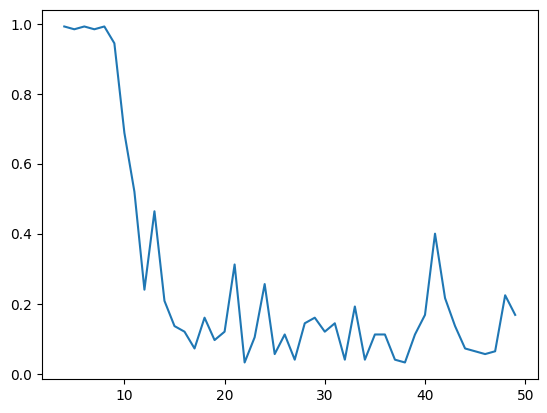

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")
V = 128
D_HIDDEN = 32
accuracies = []
lengths = []
for L in range(4, 50):
  model = MyModel(d_in = V, d_hidden = D_HIDDEN)
  model = model.to(device)
  ds = CounterDataSet(V = V, L = L)
  BATCH_SIZE = len(ds) 

  training_data = torch.utils.data.DataLoader(ds, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_fn, drop_last = True)
  losses = train(model, lr=0.1, epochs=100, train_data_loader = training_data, device = device)
  accuracy = eval_model(model, V, device)
  accuracies.append(accuracy)
  lengths.append(L)
  print(f"Sequence length {L} ---> accuracy {accuracy}")

import matplotlib.pyplot as plt
plt.plot(lengths, accuracies)  